# 📇 Add Text Descriptives as Metadata

In this tutorial, we will add text descriptives as metadata easily using the `TextDescriptivesExtractor` integrated on Argilla.

We will cover the following topics:

- 📂 Load an example dataset
- 📃 Add text descriptives to records
- 🗒️ Add text descriptives to a FeedbackDataset


## Introduction

Text descriptives are methods for analyzing and describing features of a text. They range from simple metrics like word count to more complex ones such as sentiment analysis or topic modeling, converting unstructured text into structured data easier to understand. For annotation projects, they provide information not captured by annotators, and added as metadata, they help in filtering and creating dataset subsets.

To get the text descriptives, we will use the `TextDescriptivesExtractor` based on the [TextDescriptives](https://github.com/HLasse/TextDescriptives) library. The basic metrics added by this extractor as the default are the following:

* *n_tokens*: Number of tokens in the text.
* *n_unique_tokens*: Number of unique tokens in the text.
* *n_sentences*: Number of sentences in the text.
* *perplexity*:  Measures the text complexity, vocabulary diversity and unpredictability. Lower scores suggest that the model finds the text more predictable, while a higher perplexity score means the model finds the text less predictable.
* *entropy*: Indicates text randomness or uncertainty. Higher scores denote varied, unpredictable language use.
* *flesch_reading_ease*: A readability test designed to indicate how easy an English text is to understand, based on sentence length and syllable count per word. Higher scores mean that is easier to read, while lower scores indicate complexity.

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:


**Deploy Argilla on Hugging Face Spaces**: If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/login?next=%2Fnew-space%3Ftemplate%3Dargilla%2Fargilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).


**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../getting_started/quickstart.html). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter Notebook tool of your choice.
</div>

## Set up the Environment

To complete this tutorial, you will need to install the Argilla client and a few third-party libraries using `pip`:

In [ ]:
# %pip install --upgrade pip
%pip install argilla -qqq
%pip install datasets

Let's make the needed imports:

In [4]:
import argilla as rg
from argilla.client.feedback.integrations.textdescriptives import TextDescriptivesExtractor

from datasets import load_dataset

If you are running Argilla using the Docker quickstart image or a public Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [ ]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
# Replace workspace with the name of your workspace
rg.init(
    api_url="http://localhost:6900", 
    api_key="owner.apikey",
    workspace="admin"
)

If you're running a private Hugging Face Space, you will also need to set the [HF_TOKEN](https://huggingface.co/settings/tokens) as follows:

In [ ]:
# # Set the HF_TOKEN environment variable
# import os
# os.environ['HF_TOKEN'] = "your-hf-token"

# # Replace api_url with the url to your HF Spaces URL
# # Replace api_key if you configured a custom API key
# rg.init(
#     api_url="https://[your-owner-name]-[your_space_name].hf.space", 
#     api_key="admin.apikey",
#     extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"},
# )

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running
    tutorial_running()
except ImportError:
    print("Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry.")

## Load the Dataset

For this example, we will use the [squad](https://huggingface.co/datasets/squad) dataset from Hugging Face, which is a reading comprehension dataset composed of questions on a collection of Wikipedia articles, the given context and the answers.

In [5]:
# Load the dataset and select the first 100 examples
hf_dataset = load_dataset("squad", split="train").select(range(100))

In [6]:
hf_dataset

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 100
})

## Create the FeedbackDataset

To create a FeedbackDataset, we choose a `TaskTemplate` for question answering with the default configuration, so no metadata is added.

In [7]:
# Create a FeedbackDataset
dataset = rg.FeedbackDataset.for_question_answering(
    use_markdown=True,
    guidelines=None,
    metadata_properties=None,
    vectors_settings=None,
)
dataset

FeedbackDataset(
   fields=[TextField(name='question', title='Question', required=True, type='text', use_markdown=True), TextField(name='context', title='Context', required=True, type='text', use_markdown=True)]
   questions=[TextQuestion(name='answer', title='Answer', description='Answer the question. Note that the answer must exactly be in the context.', required=True, type='text', use_markdown=True)]
   guidelines=This is a question answering dataset that contains questions and contexts. Please answer the question by using the context.)
   metadata_properties=[])
)

We will also define our initial list of records, matching the featured of the dataset with those of the task template. But for the purpose of this tutorial, we will not yet add them to our dataset.

In [8]:
# Create our list of records
records = [
    rg.FeedbackRecord(
        fields={"question": record["question"], "context": record["context"]},
    )
    for record in hf_dataset
]

## Add Text Descriptives

Our dataset currently lacks metadata. To address this, we will add the text descriptives as metadata using the `TextDescriptivesExtractor`, which has the following arguments:

* *model*: the language of the model.
* *metrics*: the metrics to be extracted.
* *visible_for_annotators*: whether the metadata is visible for annotators.
* *show_progress*: whether to show the progress bar.

For more information about the `TextDescriptivesExtractor`, please check the [practical guide](./practical_guides/create_update_dataset/metadata.md).
We can add metadata to local or remote [records](#to-records) or [datasets](#to-a-dataset). Let's see how to do both.

### To Records

First, we will add the text descriptives as metadata to the records we have defined above. To do so, we will initialize the `TextDescriptivesExtractor` where we will compute the default metrics only for the `question` field. Note that as this happens at a record level, the metadata won't be visible for annotators in the UI.

In [9]:
# Initialize the TextDescriptivesExtractor
tde = TextDescriptivesExtractor(
    model = "en",
    metrics = None,
    visible_for_annotators = False,
    show_progress = True,
)

In [ ]:
# Update the records
updated_records = tde.update_records(records, fields=["question"])

As we can see below, the default metrics for the indicated field have been added to the records as metadata.

In [11]:
updated_records[0].metadata

{'question_n_tokens': 13,
 'question_n_unique_tokens': 12,
 'question_n_sentences': 1,
 'question_perplexity': 1.27,
 'question_entropy': 0.24,
 'question_flesch_reading_ease': 89.52}

Thus, now we can add the updated records with the metadata to our dataset. And we will push it to Argilla.

In [12]:
# Add the updated records to the dataset
dataset.add_records(updated_records)

In [ ]:
# Push the dataset to Argilla
remote_dataset = dataset.push_to_argilla(name="squad_tutorial", workspace="argilla")

### To a Dataset

Now, we will update our dataset with the text descriptives for the context. In this case, we will initialize the `TextDescriptivesExtractor` indicating that we want to extract the metrics related to `descriptive_stats` and `coherence`. We will also set the `visible_for_annotators` argument to `True` so that the metadata is visible for annotators in the UI.

In [14]:
# Initialize the TextDescriptivesExtractor
tde = TextDescriptivesExtractor(
    model = "en",
    metrics = ["descriptive_stats", "readability"],
    visible_for_annotators = True,
    show_progress = True,
)

In [ ]:
# Update the dataset
tde.update_dataset(remote_dataset, fields=["context"])

In this case, it is a remote dataset so it will be updated directly on Argilla. As we can see below, the metrics have been added to the dataset as metadata and they are visible to the annotators.

In [16]:
remote_dataset.records[0].metadata

{'question_n_tokens': 13,
 'question_n_unique_tokens': 12,
 'question_n_sentences': 1,
 'question_perplexity': 1.27,
 'question_entropy': 0.24,
 'question_flesch_reading_ease': 89.52,
 'context_flesch_reading_ease': 76.96,
 'context_flesch_kincaid_grade': 6.93,
 'context_smog': 8.84,
 'context_gunning_fog': 9.34,
 'context_automated_readability_index': 8.43,
 'context_coleman_liau_index': 8.75,
 'context_lix': 34.65,
 'context_rix': 3.0,
 'context_token_length_mean': 4.46,
 'context_token_length_median': 4.0,
 'context_token_length_std': 2.55,
 'context_sentence_length_mean': 17.71,
 'context_sentence_length_median': 14.0,
 'context_sentence_length_std': 7.46,
 'context_syllables_per_token_mean': 1.32,
 'context_syllables_per_token_median': 1.0,
 'context_syllables_per_token_std': 0.69,
 'context_n_tokens': 124,
 'context_n_unique_tokens': 68,
 'context_proportion_unique_tokens': 0.55,
 'context_n_characters': 572,
 'context_n_sentences': 7}

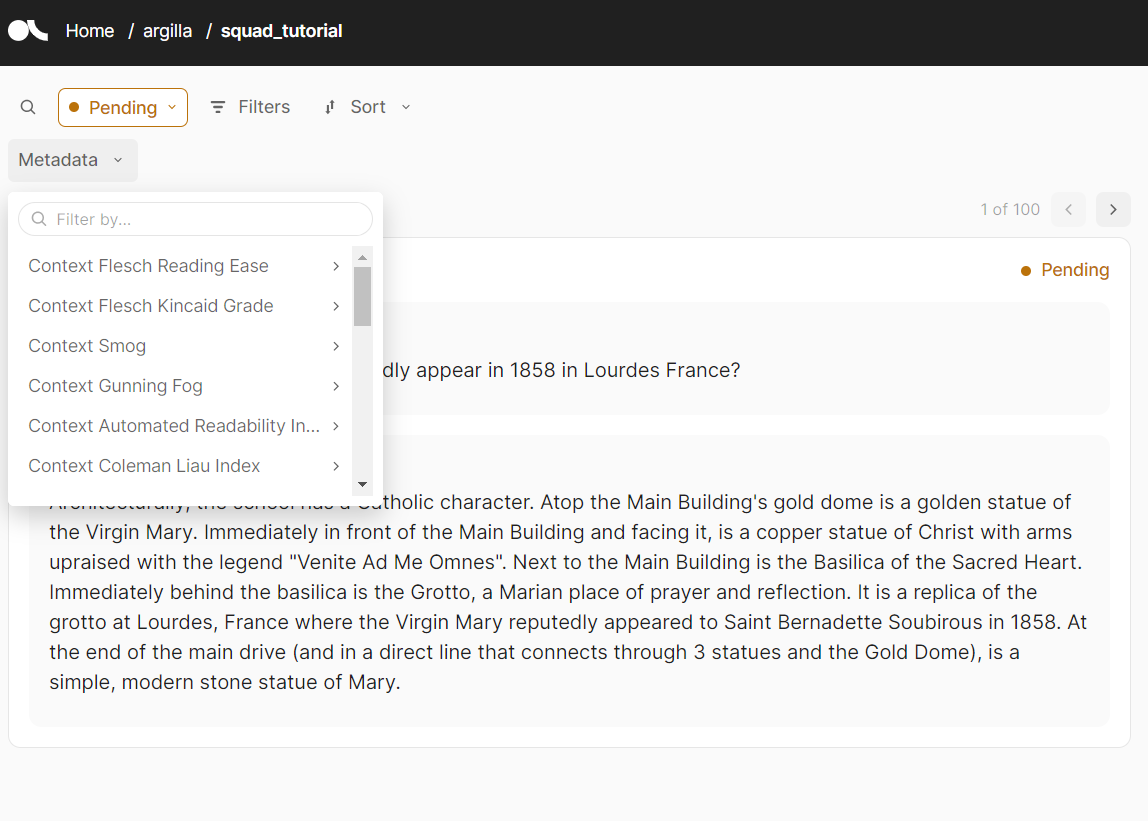

## Conclusions

In this tutorial, we have explored how to add text descriptives as metadata to records and datasets using the `TextDescriptivesExtractor` integrated on Argilla, what it is really useful for annotation projects.